In [54]:
from plantcv import plantcv as pcv
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt

from scipy import stats, ndimage, signal
from skimage import filters, morphology

import os
import pandas as pd

import utils

from importlib import reload

In [2]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

In [3]:
src = '../raw/'
time = '4pm'
rep = 7

foldername = time + ' Inc Rep ' + str(rep)
numfiles = len(glob(src + foldername + '/*.JPG'))

dst = '../preproc/prelim/'

In [71]:
idx = 250
filename = src + foldername + '/' + foldername + ' ({}).JPG'.format(idx+1)
print(filename)

raw, path, imgname = pcv.readimage(filename, mode='rgb')

#raw = raw[200:, 1140:1440, :]
raw = raw[200:, 3616:3916, :]

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (251).JPG


In [72]:
its = 15
pad = 2
rmask = (raw[:,:,1] < 75) #| (raw[:,:,1] > 170)
#rmask = v < 100
rmask = ndimage.median_filter(rmask, 11)

rmask = np.pad(rmask, pad)

bound = ndimage.convolve(rmask, boundary, mode='constant', cval=0)
bound = ndimage.binary_dilation(bound, structure = struc2, iterations=its)

fill = ndimage.binary_fill_holes(bound)
fill = fill[pad:-pad, pad:-pad]
erode = ndimage.binary_erosion(fill, structure = struc2, iterations=its, border_value=1)

In [73]:
img = raw.copy()
anti = raw.copy()
for i in range(3):
    img[:,:,i] *= erode
    anti[:,:,i] *=~erode

In [74]:
medial = np.zeros(len(erode))
for i in range(len(medial)):
    medial[i] = np.median(np.nonzero(erode[i])[0])

In [75]:
c = P.polyfit(range(len(medial)), medial,1,full=False)
print(c[1])
polyfit = c[0] + c[1]*np.arange(len(medial))

0.010596402232880152


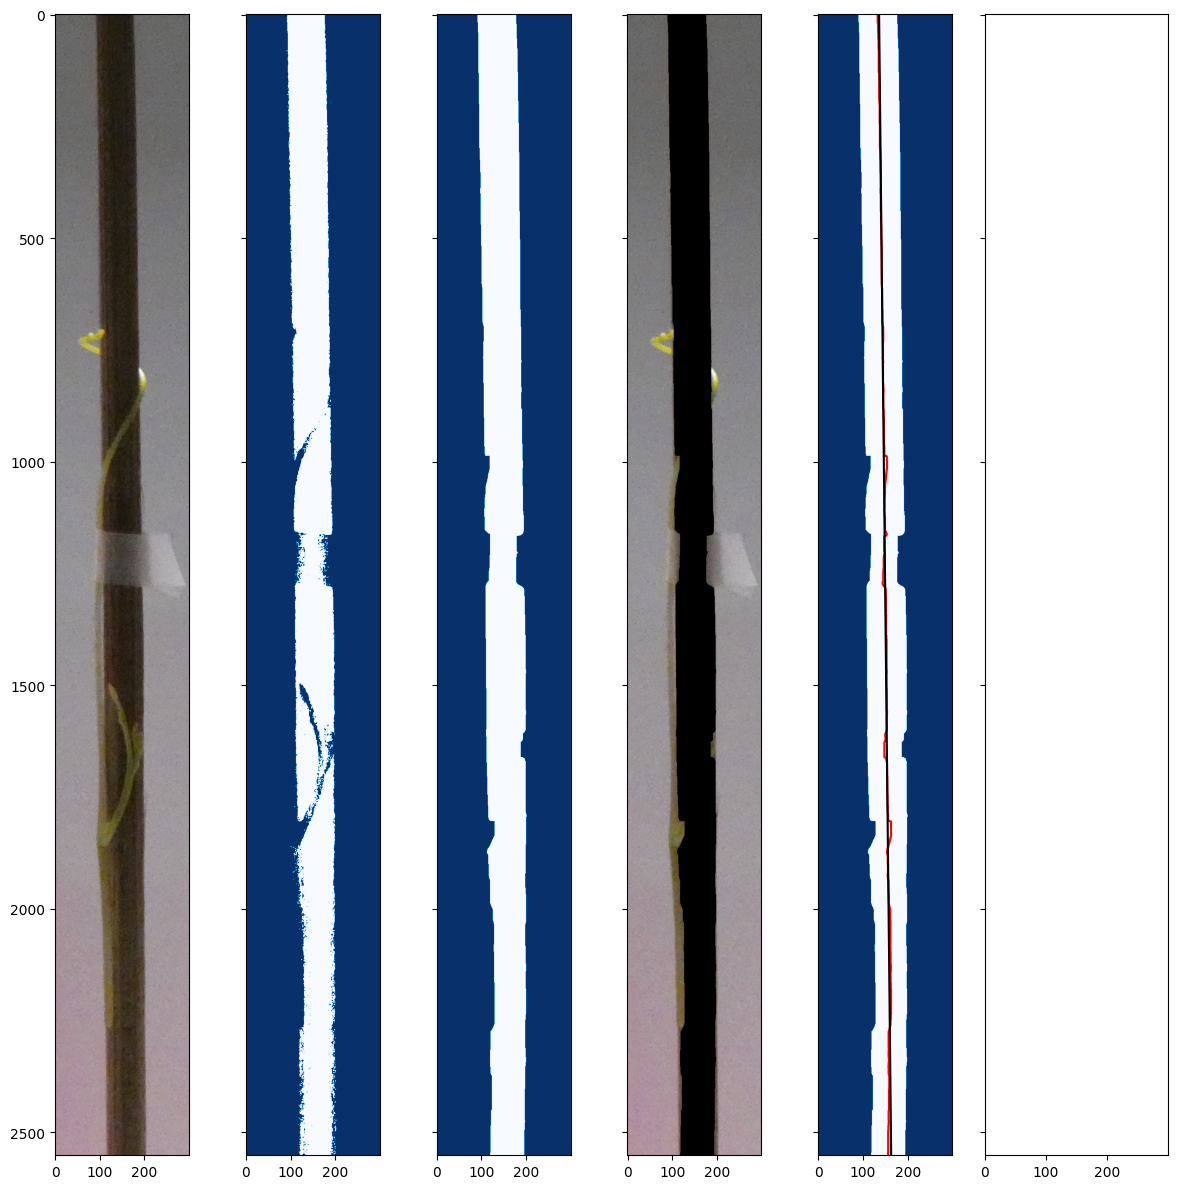

In [76]:
fig, ax = plt.subplots(1,6,figsize=(12,12), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(raw[:,:,::-1], vmin=50, vmax=51, cmap='Blues_r'); i+=1
ax[i].imshow(raw[:,:,1] < 75, vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(erode, vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(anti[:,:,::-1], vmin=50, vmax=51, cmap='Blues_r'); i+=1
ax[i].imshow(erode, vmin=0, cmap='Blues_r'); 
ax[i].plot(medial, range(len(medial)), color='r')
ax[i].plot(polyfit, range(len(medial)), color='k')

fig.tight_layout();

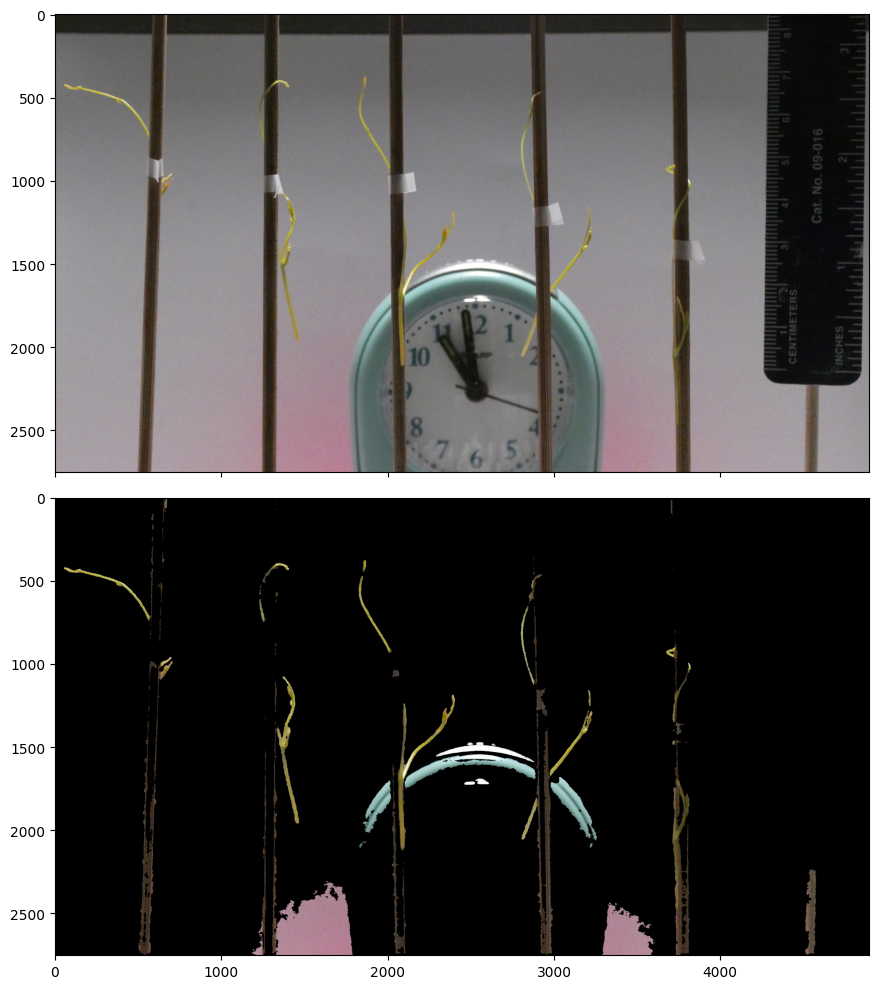

In [127]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)
ax[0].imshow(raw[:,:,::-1])
ax[1].imshow(img[:,:,::-1])
fig.tight_layout()

In [6]:
xlimit = 4200

medians = np.median(raw[:,:,0], axis=0)
peaks, foo = signal.find_peaks(255 - medians, distance=300, height=150, prominence=50)

if False:
    print(peaks,'\n',foo)
    foo = (len(hmask)-100)*medians/np.max(medians)
    fig, ax = plt.subplots(1,1,figsize=(10,7), sharex=True, sharey=False)
    ax = np.atleast_1d(ax).ravel()

    ax[0].imshow(hmask, cmap='Greys_r');
    ax[0].plot(foo, c='r', lw=2, zorder=2);
    ax[0].scatter(peaks, foo[peaks], c='blue', marker='^', zorder=3, edgecolor='magenta', s=150);
    #ax[0].plot(10*(maxis), c='b', lw=2);

5


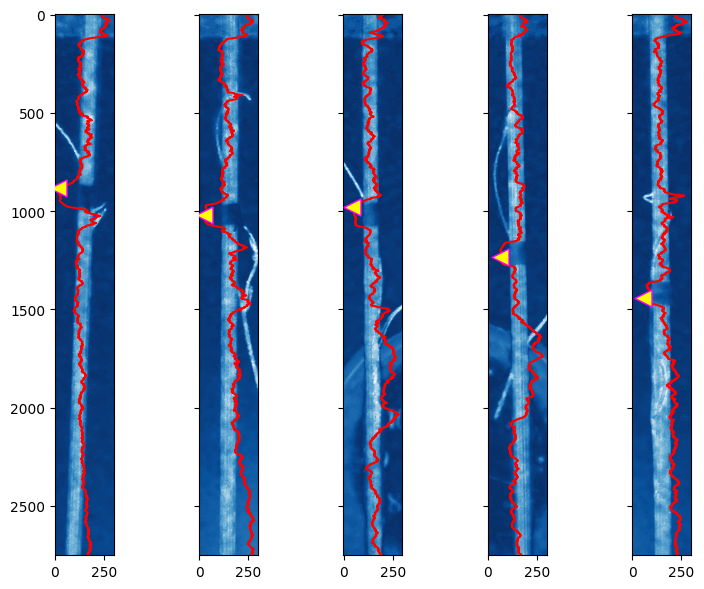

In [7]:
buffx = 0
buffy = 150
stick = []

for i in range(len(peaks)-1):
    stick.append(np.s_[:, peaks[i]-buffy:peaks[i]+buffy])
print(len(stick))
tapes = np.zeros(len(stick), dtype=int)

fig, ax = plt.subplots(1,len(stick),figsize=(8,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    medians = np.sum(s[stick[i]], axis=1)
    foo = 2*(buffy-10)*medians/np.max(medians)
    
    tapes[i] = np.argmin(medians)
    
    ax[i].imshow((s)[stick[i]], vmin=0, cmap='Blues_r')
    ax[i].plot(foo, range(len(foo)), c='r')
    ax[i].scatter([foo[tapes[i]]], [tapes[i]], c='yellow', marker='<', zorder=3, edgecolor='magenta', s=150);
fig.tight_layout();

In [9]:
j = 4

hmask = h.copy()
hmask[h > 40] = 0
hmask[hmask > 0] = 1
vmask = hmask & stdmask
foo = (v*vmask)[stick[j]]
mask = vmask & (v > np.median(foo[foo > 0]))

In [10]:
median = ndimage.median_filter(mask, size=11)

In [69]:
smask = (rawstd > 300).astype(np.uint8)

In [70]:
iters = 10
#dilate = ndimage.binary_dilation(vmask, iterations=4)
#dilate = ndimage.binary_fill_holes(dilate)
erode = ndimage.binary_erosion(vmask, iterations=iters)
layers = (erode | smask) & median

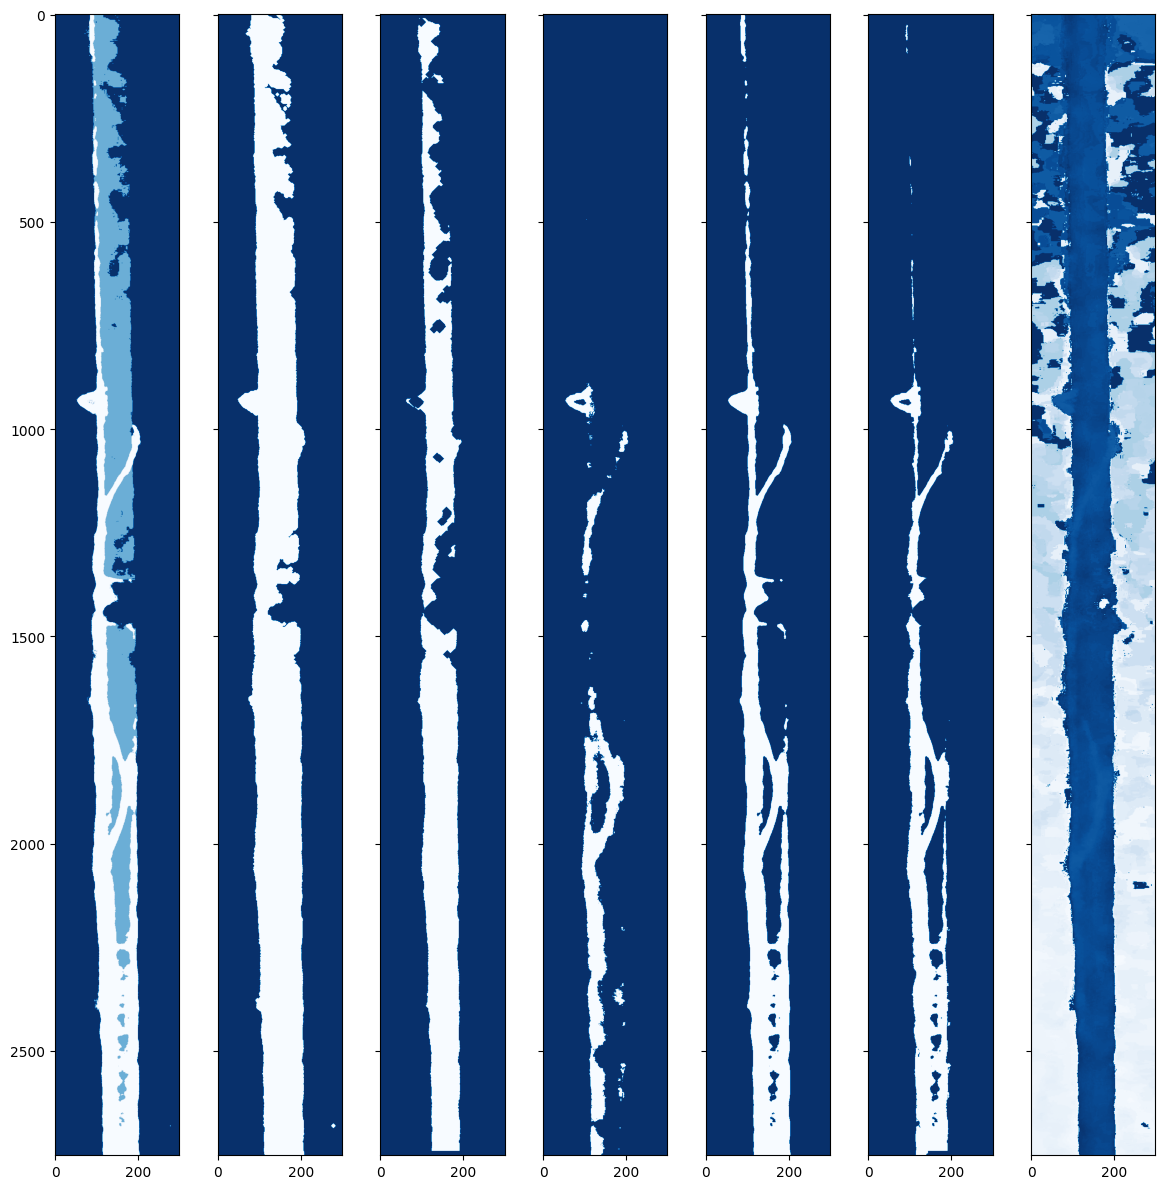

In [72]:
fig, ax = plt.subplots(1,7,figsize=(12,12), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow((median+vmask)[stick[j]], vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(dilate[stick[j]], vmin=0,cmap='Blues_r'); i+=1
ax[i].imshow(erode[stick[j]], vmin=0,cmap='Blues_r'); i+=1
ax[i].imshow(smask[stick[j]], vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(median[stick[j]], vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(layers[stick[j]], vmin=0, cmap='Blues_r'); i+=1
ax[i].imshow(h[stick[j]], vmin=0,cmap='Blues_r'); i+=1

fig.tight_layout();

In [9]:
buffx = 200
buffy = 50
plants = []

plants.append(np.s_[buffx:tapes[0], 0:peaks[1]-buffy])

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i], peaks[i-1]+buffy:peaks[i+1]-buffy])

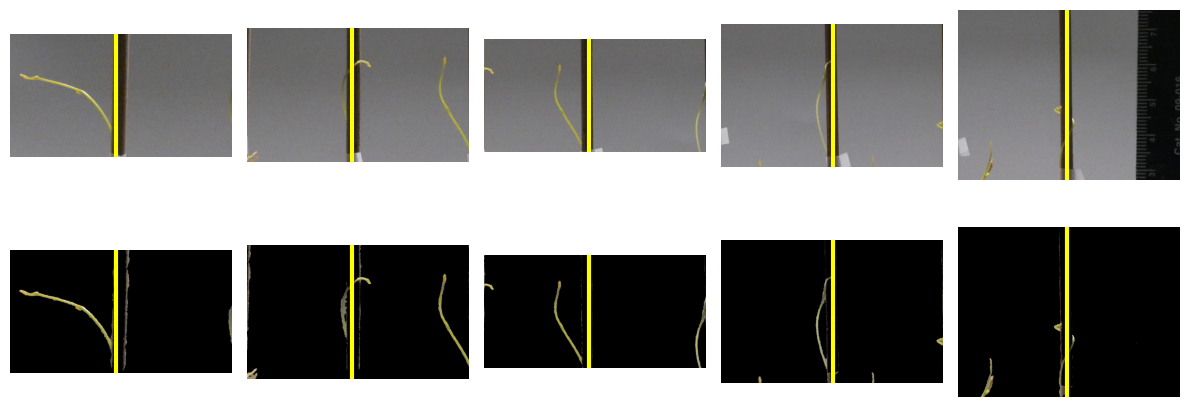

In [12]:
fig, ax = plt.subplots(2,len(plants),figsize=(12,5))
ax = np.atleast_1d(ax).ravel()

for i in range(len(plants)):
    ax[i+len(plants)].imshow(img[plants[i]][:,:,::-1], vmin=0)
    ax[i].imshow(raw[plants[i]][:,:,::-1], vmin=0)

    ax[i].axvline(peaks[i]-plants[i][1].start, c='yellow', lw=3)
    ax[i+len(plants)].axvline(peaks[i]-plants[i][1].start, c='yellow', lw=3)
    
for i in range(len(ax)):
    ax[i].axis('off');
    
fig.tight_layout();

In [16]:
i = 4
anchory = peaks[i]-plants[i][1].start

patch = img[plants[i]][:,:,::-1]
rpatch = raw[plants[i]][:,:,::-1]

median = ndimage.median_filter(patch[:,:,1], size=11)
median[median < 50] = 0
median[median > 0] = 1
#median = ndimage.binary_dilation(median, iterations=8)

labels,num = ndimage.label(median, structure=ndimage.generate_binary_structure(median.ndim, 1))

In [17]:
minsize = 100
comp_size = np.zeros(num, dtype=int)
feret = np.zeros((num,2))
touch = np.zeros((num,4))
dtouch = np.zeros((num,2), dtype=int)

for i in range(num):
    box = median.copy()
    box[labels != i+1] = 0

    coords = np.asarray(np.nonzero(box))
    feret[i] = np.max(coords, axis=1) - np.min(coords, axis=1) + np.array([1,1])
    comp_size[i] = len(coords[1])
    
    foo = np.abs(anchory - coords[1])
    
    bar = np.argmin(foo)
    dtouch[i,0] = foo[bar]
    touch[i,:2] = coords[:,bar]
    
    bar = np.argmax(foo)
    dtouch[i,1] = foo[bar]
    touch[i,2:] = coords[:,bar]
    
f_ratio = np.divide(*np.sort(feret, axis=1).T) 

In [18]:
df = pd.DataFrame(np.column_stack((comp_size, feret, dtouch)), dtype=int,
                  columns = ['size', 'feret_x', 'feret_y', 'd_min', 'd_max'])
df['ratio'] = f_ratio
df

,size,feret_x,feret_y,d_min,d_max,ratio
0,5,1,5,51,55,0.200000
1,46,8,6,51,56,0.750000
2,26,6,5,51,55,0.833333
3,44,11,5,49,53,0.454545
4,78,13,7,47,53,0.538462
5,3077,139,60,38,97,0.431655
6,1530,111,37,18,54,0.333333
7,465,64,10,41,50,0.156250
8,7545,331,75,0,60,0.226586
9,7575,281,93,537,629,0.330961


In [19]:
comp_mask = ((feret[:,1] > 50) | (f_ratio > 0.35)) & (comp_size > 100) & (dtouch[:,0] < 50)

size_mask = comp_size/np.sum(comp_size[comp_mask]) > 0.05

mask = comp_mask & size_mask

box = np.zeros_like(labels).astype(bool)
comp_labels = np.nonzero(mask)[0]

for i in comp_labels:
    box[labels == i+1] = True
#box = ndimage.binary_erosion(box, iterations=8)

In [138]:
print(comp_size[comp_mask])
print(comp_size[comp_mask]/np.sum(comp_size[comp_mask]))

[  595 27466   256]
[0.02101211 0.96994738 0.00904051]


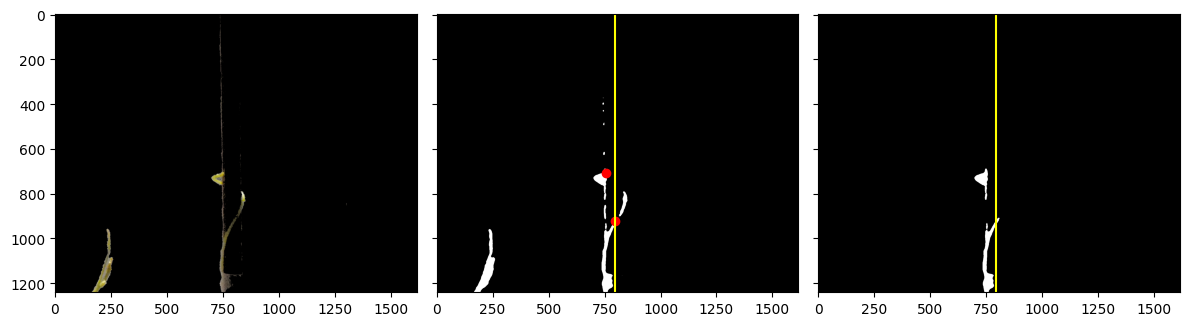

In [20]:
fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch, origin='lower');

ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[1].scatter(touch[mask, 1], touch[mask, 0], c='red')
ax[1].axvline(anchory, c='yellow')

ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)
ax[2].axvline(anchory, c='yellow')

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

In [134]:
coords = np.asarray(np.nonzero(labels))
coords

array([[  0,   0,   0, ..., 476, 476, 476],
       [649, 650, 651, ..., 567, 568, 569]])

In [135]:
root = np.max(coords[0])
foo = coords[:,coords[0] == root]
foo = np.min(foo[1])
root = np.array([foo, root])
print('Root:\t', root)

Root:	 [566 476]


In [149]:
vine = []
advance_nw = True
advance_ne = True

posx, posy = root
jumplim = 15

while advance_nw:
    vine.append(np.array([posx, posy]))
    
    # go left
    if labels[posy, posx-1]:
        posx -= 1
    
    # go NW
    elif labels[posy-1, posx-1]:
        posx -= 1; posy -= 1
    
    # go up
    elif labels[posy-1, posx]:
        posy -= 1
        
    # go NE
    elif labels[posy-1, posx+1]:
        posx += 1; posy -= 1
    
    # try jumping
    else:
        jumparr = np.nonzero(labels[posy-jumplim:posy, posx])[0]
        
        # jump up
        if len(jumparr) > 0:
            jump = jumplim - jumparr[-1]
            posy -= jump
    
        else:
            advance_nw = False

vine = np.asarray(vine)
len(vine)

362

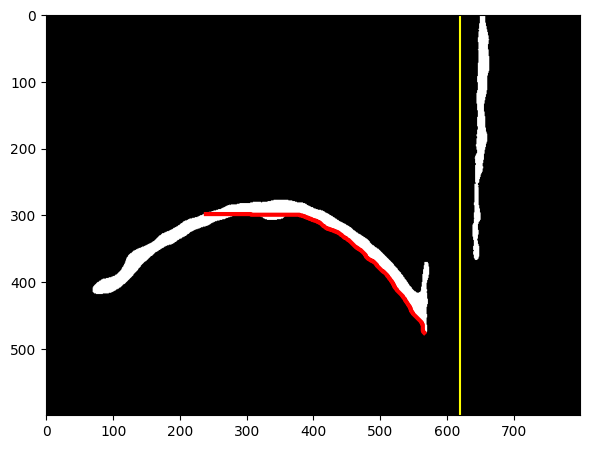

In [150]:
fig, ax = plt.subplots(1,1,figsize=(6,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(labels, cmap='Greys_r', vmin=0)
ax[0].axvline(anchory, c='yellow')
#ax[0].scatter([root[0]], [root[1]], marker='D', color='yellow', s=150, edgecolor='red', zorder=10)
ax[0].plot(vine[:,0], vine[:,1], c='red', lw=3, zorder=1)

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

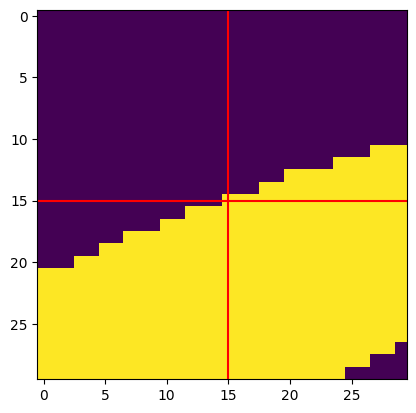

In [151]:
buff = jumplim
view = np.s_[vine[-1,1]-buff:vine[-1,1]+buff, vine[-1,0]-buff:vine[-1,0]+buff]
plt.imshow(labels[view])
plt.axvline(buff, c='r')
plt.axhline(buff, c='r')

In [ ]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [24]:
peaks

array([ 593, 1281, 2062, 2921, 3771, 4430])

In [ ]:
jdx = 4
fig, ax = plt.subplots(2,len(stick),figsize=(12,10))

ax = ax.ravel()

for i in range(len(stick)):
    ax[i].imshow(img[stick[i]][:,:,::-1]);
    ax[i].axis('off')
    
    ax[i+5].imshow(np.max(img[stick[i]], axis=2), vmax=1)
    ax[i+5].axis('off')

fig.tight_layout()

In [ ]:
i = 0

hsv = cv2.cvtColor(img[stick[i]], cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

fig, ax = plt.subplots(1,4,figsize=(12,7), sharex=True, sharey=True)

ax[0].imshow(h, cmap='inferno');
ax[1].imshow(s, cmap='inferno');
ax[2].imshow(v, cmap='inferno', vmin=0, vmax=255);
ax[3].imshow(img[stick[i]])

fig.tight_layout()

In [ ]:
plt.imshow(v > 62, cmap='Greys_r');